#### Persiapan

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv('heart_statlog_cleveland_hungary_final_cleaned.csv')
display(df)
X_data = df.copy().drop(columns=['target'])
y_data = df.copy()['target']

,age,sex,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,target,chest pain type_2,chest pain type_3,chest pain type_4,ST slope_1,ST slope_2,ST slope_3
0,-1.432206,1,0.414627,0.896615,0,0,1.383339,0,-0.831502,0,True,False,False,True,False,False
1,-0.478057,0,1.526360,-1.122657,0,0,0.754736,0,0.106251,1,False,True,False,False,True,False
2,-1.750256,1,-0.141240,0.785462,0,1,-1.523953,0,-0.831502,0,True,False,False,True,False,False
3,-0.584074,0,0.303453,-0.492793,0,0,-1.131075,1,0.575128,1,False,False,True,False,True,False
4,0.052026,1,0.970493,-0.844776,0,0,-0.581047,0,-0.831502,0,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,-0.902124,1,-1.252973,0.433479,0,0,-0.188170,0,0.293802,1,False,False,False,False,True,False
913,1.536257,1,0.636973,-0.881827,1,0,0.165420,0,2.356860,1,False,False,True,False,True,False
914,0.370075,1,-0.141240,-2.030404,0,0,-0.856061,1,0.293802,1,False,False,True,False,True,False
915,0.370075,0,-0.141240,-0.085233,0,2,1.461915,0,-0.831502,1,True,False,False,False,True,False


#### Model Logistic Regression

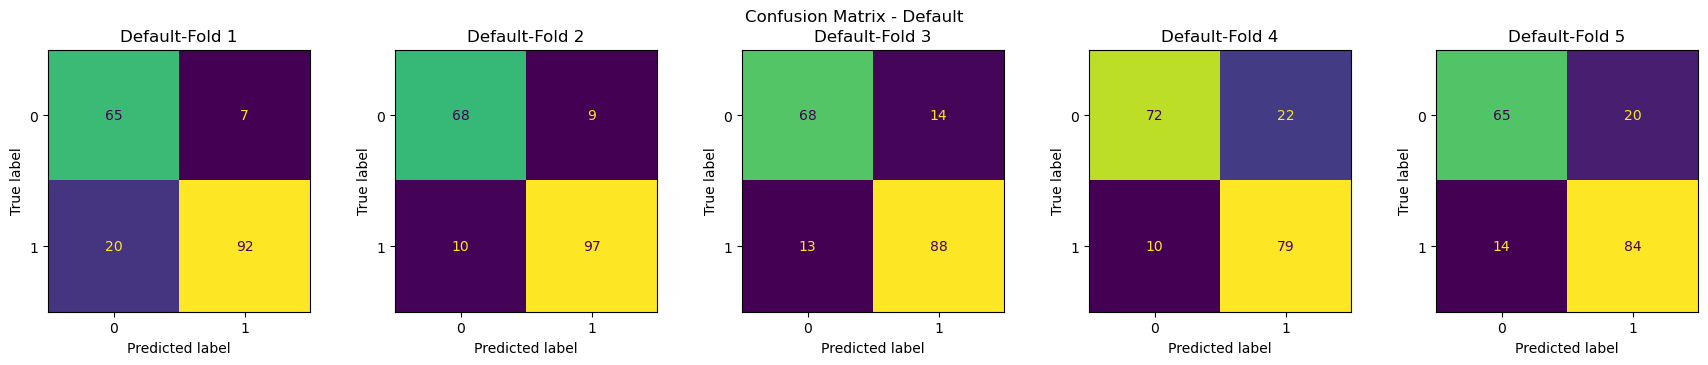

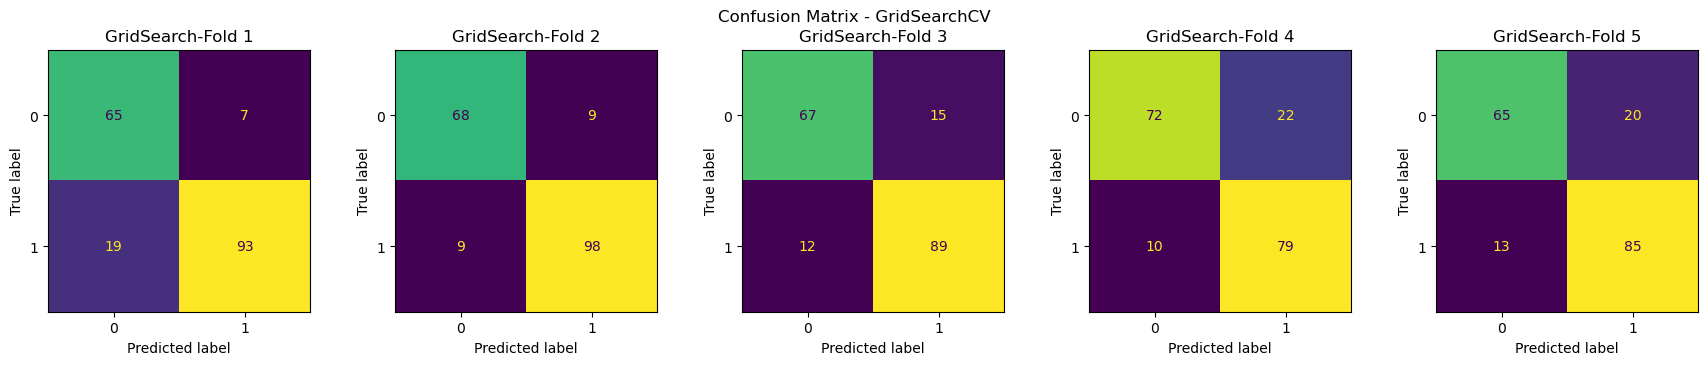

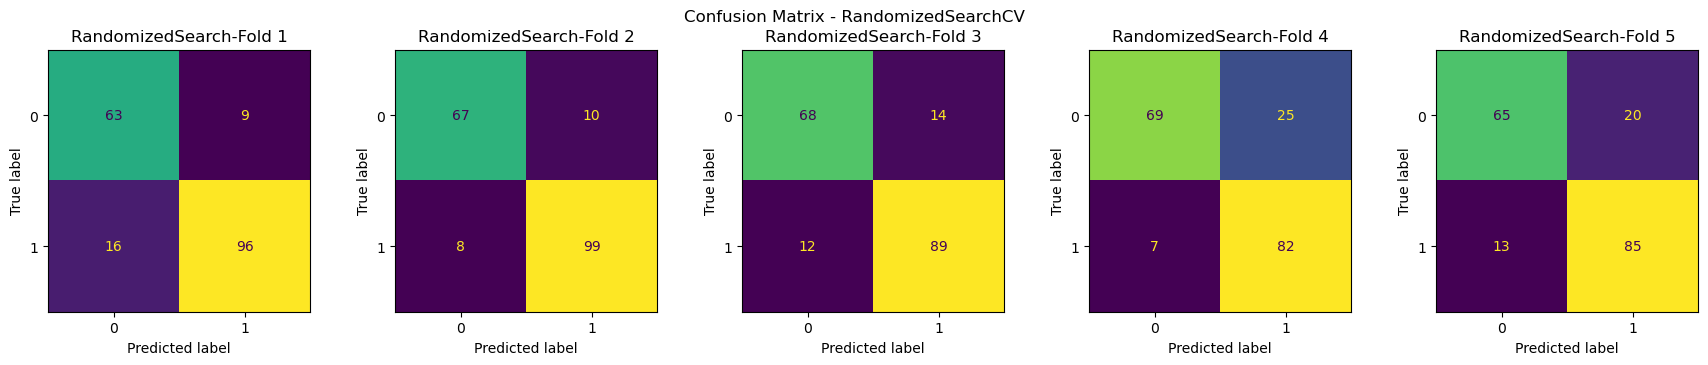

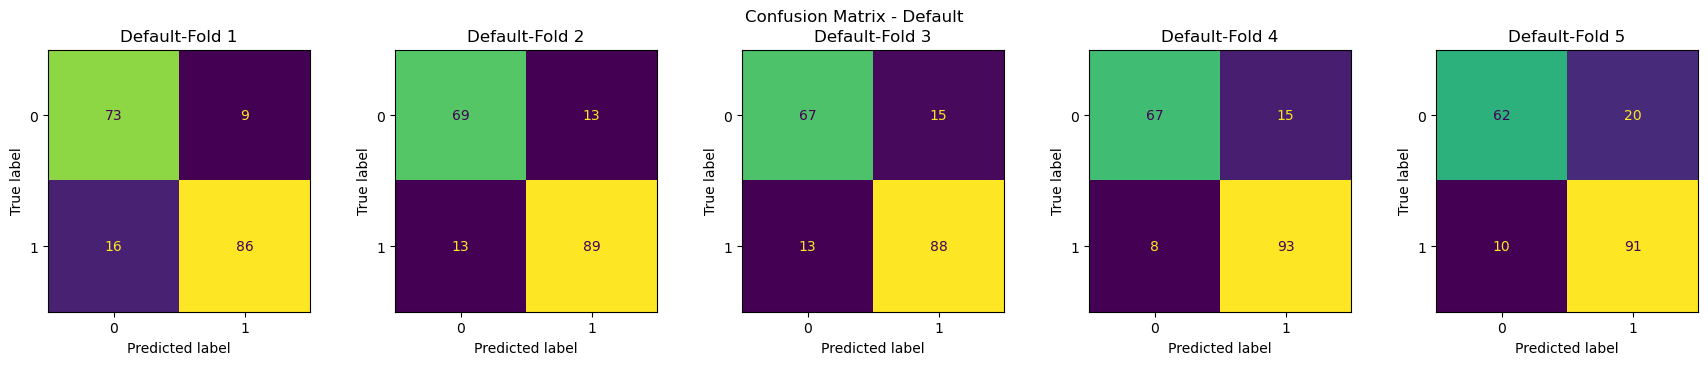

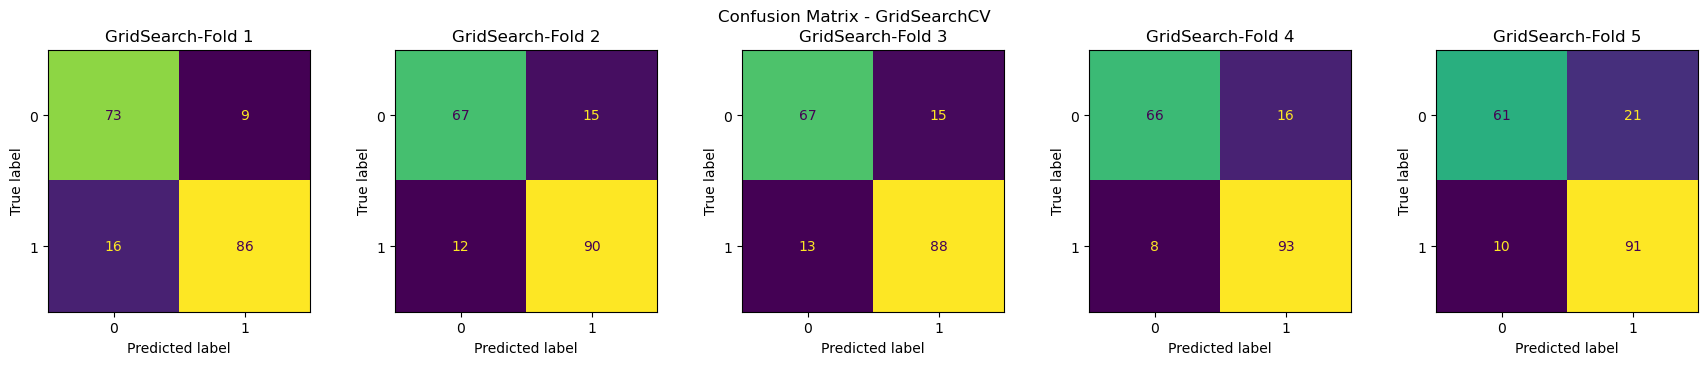

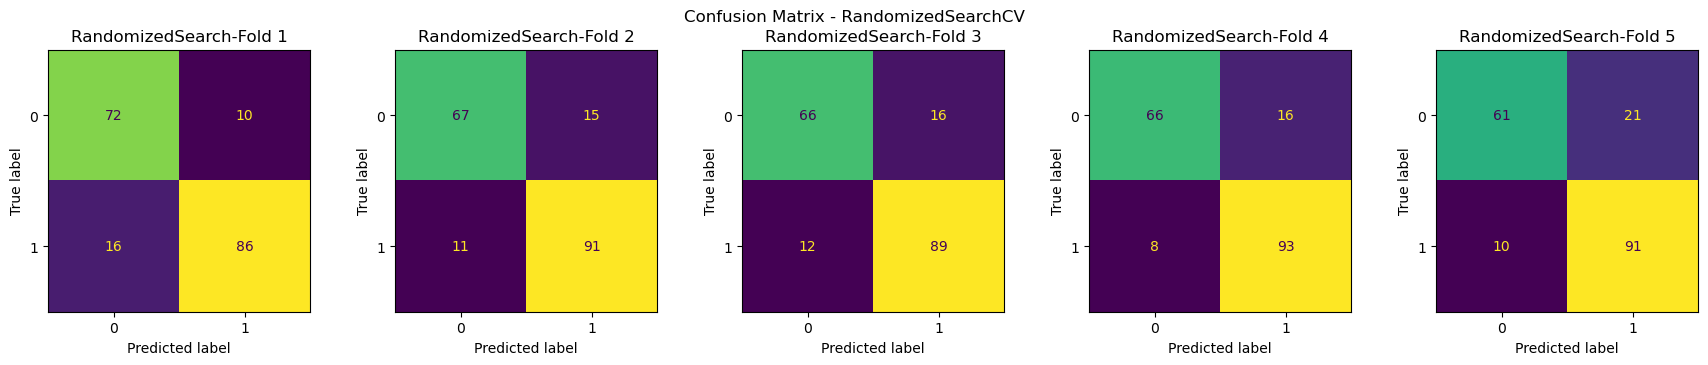

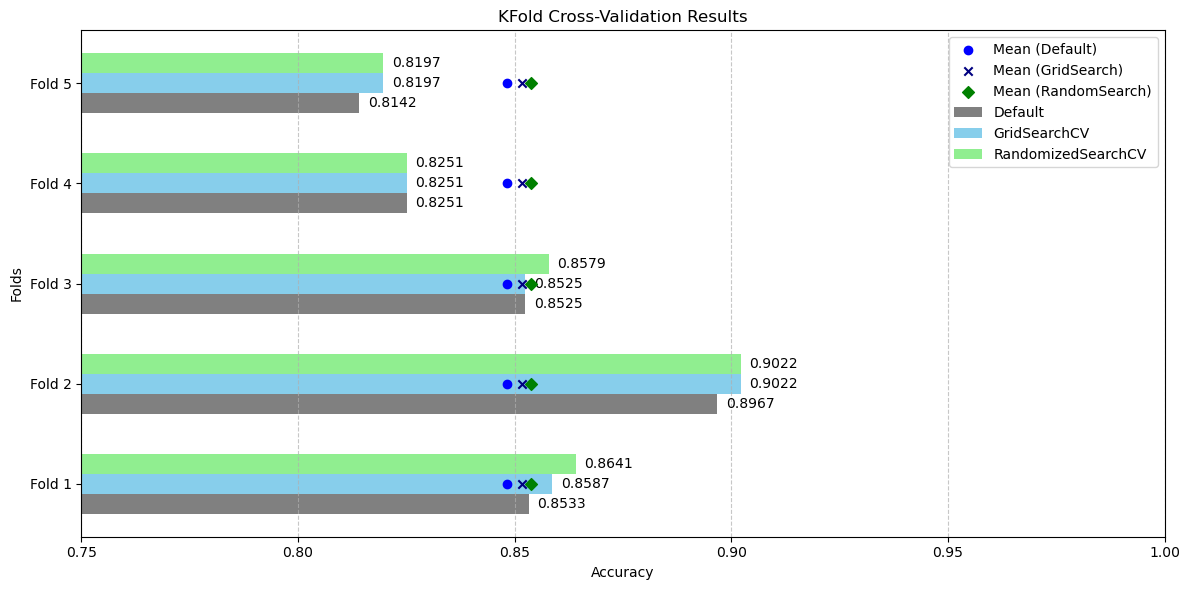

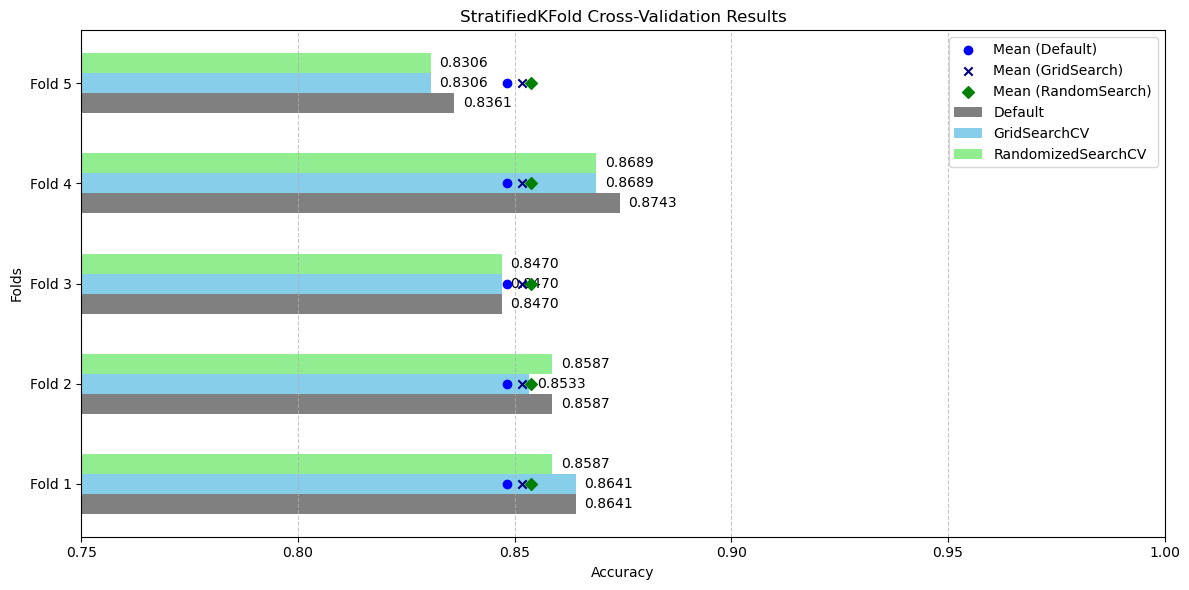

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from scipy.stats import loguniform, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


X = X_data.copy().to_numpy()
y = y_data.copy().to_numpy()


# Function untuk membuat pipeline model
def create_pipeline(C=1.0):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(C=C, max_iter=1000, solver='liblinear'))
    ])

param_dist = {
    'clf__C': loguniform(0.001, 100),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['saga'],
    # 'clf__l1_ratio': [0.1, 0.5, 0.9],
    'clf__max_iter': randint(2000, 5000)
}

# Hyperparameter settings
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['saga'],
    # 'clf__l1_ratio': [0.1, 0.5, 0.9],
    'clf__max_iter': [5000, 10000]
}

# Fungsi evaluasi untuk KFold dan StratifiedKFold
def evaluate_with_cv(cv_method, use_grid=False, use_random=False, show_conf_matrix=False):
    default_scores = []
    grid_scores = []
    random_scores = []
    fold_num = 1

    # Untuk menyimpan semua confusion matrices
    conf_matrices_default = []
    conf_matrices_grid = []
    conf_matrices_random = []

    for train_idx, test_idx in cv_method.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default
        model = create_pipeline()
        model.fit(X_train, y_train)
        default_scores.append(model.score(X_test, y_test))

        if show_conf_matrix:
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            conf_matrices_default.append((cm, f"Default-Fold {fold_num}"))

        # GridSearchCV
        if use_grid:
            grid = GridSearchCV(create_pipeline(), param_grid, cv=3)
            grid.fit(X_train, y_train)
            grid_scores.append(grid.best_estimator_.score(X_test, y_test))
            
            if show_conf_matrix:
                y_pred = grid.best_estimator_.predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                conf_matrices_grid.append((cm, f"GridSearch-Fold {fold_num}"))

        # RandomizedSearchCV
        if use_random:
            rand = RandomizedSearchCV(create_pipeline(), param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
            rand.fit(X_train, y_train)
            random_scores.append(rand.best_estimator_.score(X_test, y_test))
            
            if show_conf_matrix:
                y_pred = rand.best_estimator_.predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                conf_matrices_random.append((cm, f"RandomizedSearch-Fold {fold_num}"))

        fold_num += 1

    # Tampilkan semua confusion matrix setelah loop
    if show_conf_matrix:
        plot_multiple_confusion_matrices(conf_matrices_default, "Confusion Matrix - Default")
        if use_grid:
            plot_multiple_confusion_matrices(conf_matrices_grid, "Confusion Matrix - GridSearchCV")
        if use_random:
            plot_multiple_confusion_matrices(conf_matrices_random, "Confusion Matrix - RandomizedSearchCV")

    return default_scores, grid_scores, random_scores

def plot_multiple_confusion_matrices(conf_matrices, title):
    n = len(conf_matrices)
    fig, axes = plt.subplots(1, n, figsize=(3.5 * n, 3.5))

    if n == 1:
        axes = [axes]

    for i, (cm, name) in enumerate(conf_matrices):
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[i], colorbar=False)
        axes[i].set_title(name)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  # Pastikan hanya panggil show sekali di sini
    plt.close(fig)  # ⬅⬅⬅ Tambahkan ini untuk menghindari dobel



# Evaluasi untuk KFold dan StratifiedKFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

kfold_default, kfold_grid, kfold_random = evaluate_with_cv(kfold, use_grid=True, use_random=True, show_conf_matrix=True)
strat_default, strat_grid, strat_random = evaluate_with_cv(strat_kfold, use_grid=True, use_random=True, show_conf_matrix=True)

# Fungsi plotting hasil
def plot_fold_results(fold_scores_dict, title):
    folds = [f'Fold {i+1}' for i in range(len(next(iter(fold_scores_dict.values()))))]
    y_pos = np.arange(len(folds))

    plt.figure(figsize=(12, 6))
    
    bar_height = 0.2
    offsets = [-bar_height, 0, bar_height]
    colors = ['gray', 'skyblue', 'lightgreen']
    labels = ['Default', 'GridSearchCV', 'RandomizedSearchCV']

    for i, (label, scores) in enumerate(fold_scores_dict.items()):
        plt.barh(y_pos + offsets[i], scores, height=bar_height, color=colors[i], label=labels[i])
        for j, score in enumerate(scores):
            plt.text(score + 0.002, y_pos[j] + offsets[i], f"{score:.4f}", va='center', ha='left')

    # Hitung mean dari masing-masing
    mean_default = np.mean(kfold_default)
    mean_grid = np.mean(kfold_grid)
    mean_random = np.mean(kfold_random)
    
    # Tambahkan titik/marker sebagai legend dan penanda mean
    plt.scatter([mean_default]*len(kfold_default), range(len(kfold_default)),
                marker='o', color='blue', label='Mean (Default)', zorder=5)
    
    plt.scatter([mean_grid]*len(kfold_grid), range(len(kfold_grid)),
                marker='x', color='navy', label='Mean (GridSearch)', zorder=5)
    
    plt.scatter([mean_random]*len(kfold_random), range(len(kfold_random)),
                marker='D', color='green', label='Mean (RandomSearch)', zorder=5)
    plt.xlim(0.75, 1.0)

    plt.xlabel('Accuracy')
    plt.ylabel('Folds')
    plt.yticks(y_pos, folds)
    plt.title(title)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot hasil
plot_fold_results({
    'Default': kfold_default,
    'GridSearchCV': kfold_grid,
    'RandomizedSearchCV': kfold_random
}, 'KFold Cross-Validation Results')

plot_fold_results({
    'Default': strat_default,
    'GridSearchCV': strat_grid,
    'RandomizedSearchCV': strat_random
}, 'StratifiedKFold Cross-Validation Results')


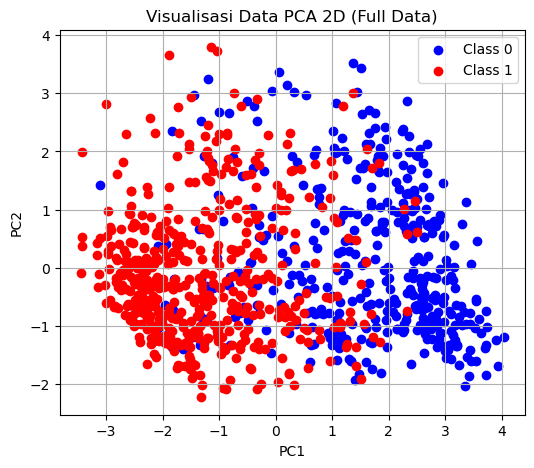

In [4]:
def run_pipeline_with_visualization_full(X, y, pipeline_fn=create_pipeline, **pipeline_kwargs):
    """
    Train + Visualisasi pipeline di seluruh data (tanpa split).
    
    Parameters:
    - X, y : dataset
    - pipeline_fn : fungsi pembuat pipeline
    - **pipeline_kwargs : argumen tambahan untuk pipeline (misal: C=0.1)
    """
    # 1. Buat pipeline
    pipeline = pipeline_fn(**pipeline_kwargs)

    # 2. Fit di seluruh data
    pipeline.fit(X, y)

    # 3. Transform ke PCA space
    X_pca_all = pipeline.named_steps['pca'].transform(
        pipeline.named_steps['scaler'].transform(X)
    )

    # --- Visualisasi sebelum training ---
    plt.figure(figsize=(6, 5))
    plt.title("Visualisasi Data PCA 2D (Full Data)")
    plt.scatter(X_pca_all[y==0, 0], X_pca_all[y==0, 1], c='blue', label='Class 0')
    plt.scatter(X_pca_all[y==1, 0], X_pca_all[y==1, 1], c='red', label='Class 1')
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(); plt.grid(True)
    plt.show()

    # # --- Visualisasi decision boundary ---
    # x_min, x_max = X_pca_all[:, 0].min() - 1, X_pca_all[:, 0].max() + 1
    # y_min, y_max = X_pca_all[:, 1].min() - 1, X_pca_all[:, 1].max() + 1
    # xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
    #                      np.linspace(y_min, y_max, 300))
    # grid_pca = np.c_[xx.ravel(), yy.ravel()]
    # grid_original = pipeline.named_steps['scaler'].inverse_transform(
    #     pipeline.named_steps['pca'].inverse_transform(grid_pca)
    # )
    # Z = pipeline.predict(grid_original).reshape(xx.shape)

    # plt.figure(figsize=(6, 5))
    # plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    # plt.scatter(X_pca_all[y==0, 0], X_pca_all[y==0, 1], c='blue', label='Class 0')
    # plt.scatter(X_pca_all[y==1, 0], X_pca_all[y==1, 1], c='red', label='Class 1')
    # plt.title("Decision Boundary (Full Data)")
    # plt.xlabel("PC1"); plt.ylabel("PC2")
    # plt.legend(); plt.grid(True)
    # plt.show()

    return pipeline

    
pipeline = run_pipeline_with_visualization_full(X, y, pipeline_fn=create_pipeline, C=0.1)

#### K-Nearest Neighbor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

X = X_data.copy().to_numpy()
y = y_data.copy().to_numpy()

# Function untuk membuat pipeline model
def create_pipeline(n_neighbors=5, weights='uniform', metric='minkowski'):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric))
    ])

# Parameter untuk RandomizedSearchCV
param_dist = {
    'clf__n_neighbors': randint(1, 20),
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['minkowski', 'euclidean', 'manhattan'],
}

# Parameter untuk GridSearchCV
param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9, 11],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['minkowski', 'euclidean', 'manhattan'],
}

# Fungsi evaluasi untuk KFold dan StratifiedKFold
def evaluate_with_cv(cv_method, use_grid=False, use_random=False, show_conf_matrix=False):
    default_scores = []
    grid_scores = []
    random_scores = []
    fold_num = 1

    # Untuk menyimpan semua confusion matrices
    conf_matrices_default = []
    conf_matrices_grid = []
    conf_matrices_random = []

    for train_idx, test_idx in cv_method.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Default
        model = create_pipeline()
        model.fit(X_train, y_train)
        default_scores.append(model.score(X_test, y_test))

        if show_conf_matrix:
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            conf_matrices_default.append((cm, f"Default-Fold {fold_num}"))

        # GridSearchCV
        if use_grid:
            grid = GridSearchCV(create_pipeline(), param_grid, cv=3)
            grid.fit(X_train, y_train)
            grid_scores.append(grid.best_estimator_.score(X_test, y_test))
            
            if show_conf_matrix:
                y_pred = grid.best_estimator_.predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                conf_matrices_grid.append((cm, f"GridSearch-Fold {fold_num}"))

        # RandomizedSearchCV
        if use_random:
            rand = RandomizedSearchCV(create_pipeline(), param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
            rand.fit(X_train, y_train)
            random_scores.append(rand.best_estimator_.score(X_test, y_test))
            
            if show_conf_matrix:
                y_pred = rand.best_estimator_.predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                conf_matrices_random.append((cm, f"RandomizedSearch-Fold {fold_num}"))

        fold_num += 1

    # Tampilkan semua confusion matrix setelah loop
    if show_conf_matrix:
        plot_multiple_confusion_matrices(conf_matrices_default, "Confusion Matrix - Default")
        if use_grid:
            plot_multiple_confusion_matrices(conf_matrices_grid, "Confusion Matrix - GridSearchCV")
        if use_random:
            plot_multiple_confusion_matrices(conf_matrices_random, "Confusion Matrix - RandomizedSearchCV")

    return default_scores, grid_scores, random_scores

def plot_multiple_confusion_matrices(conf_matrices, title):
    n = len(conf_matrices)
    fig, axes = plt.subplots(1, n, figsize=(3.5 * n, 3.5))

    if n == 1:
        axes = [axes]

    for i, (cm, name) in enumerate(conf_matrices):
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[i], colorbar=False)
        axes[i].set_title(name)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  # Pastikan hanya panggil show sekali di sini
    plt.close(fig)  # ⬅⬅⬅ Tambahkan ini untuk menghindari dobel

# Evaluasi untuk KFold dan StratifiedKFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

kfold_default, kfold_grid, kfold_random = evaluate_with_cv(kfold, use_grid=True, use_random=True, show_conf_matrix=True)
strat_default, strat_grid, strat_random = evaluate_with_cv(strat_kfold, use_grid=True, use_random=True, show_conf_matrix=True)

# Fungsi plotting hasil
def plot_fold_results(fold_scores_dict, title, labels):
    folds = [f'Fold {i+1}' for i in range(len(next(iter(fold_scores_dict.values()))))]
    y_pos = np.arange(len(folds))

    plt.figure(figsize=(12, 6))

    bar_height = 0.2
    offsets = [-bar_height, 0, bar_height]
    colors = ['gray', 'skyblue', 'lightgreen']
    labels_legend = ['Default', 'GridSearchCV', 'RandomizedSearchCV']

    for i, (label, scores) in enumerate(fold_scores_dict.items()):
        plt.barh(y_pos + offsets[i], scores, height=bar_height, color=colors[i], label=labels_legend[i])
        for j, score in enumerate(scores):
            plt.text(score + 0.002, y_pos[j] + offsets[i], f"{score:.4f}", va='center', ha='left')

    # Hitung mean dari masing-masing
    mean_default = np.mean(kfold_default)
    mean_grid = np.mean(kfold_grid)
    mean_random = np.mean(kfold_random)

    # Tambahkan titik/marker sebagai legend dan penanda mean
    plt.scatter([mean_default]*len(kfold_default), range(len(kfold_default)),
                marker='o', color='blue', label='Mean (Default)', zorder=5)

    plt.scatter([mean_grid]*len(kfold_grid), range(len(kfold_grid)),
                marker='x', color='navy', label='Mean (GridSearch)', zorder=5)

    plt.scatter([mean_random]*len(kfold_random), range(len(kfold_random)),
                marker='D', color='green', label='Mean (RandomSearch)', zorder=5)
    plt.xlim(0.75, 1.0)

    plt.xlabel('Accuracy')
    plt.ylabel('Folds')
    plt.yticks(y_pos, folds)
    plt.title(title)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot hasil
plot_fold_results({
    'Default': kfold_default,
    'GridSearchCV': kfold_grid,
    'RandomizedSearchCV': kfold_random
}, 'KFold Cross-Validation Results', kfold_labels)

plot_fold_results({
    'Default': strat_default,
    'GridSearchCV': strat_grid,
    'RandomizedSearchCV': strat_random
}, 'StratifiedKFold Cross-Validation Results', strat_labels)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from scipy.stats import randint, uniform

# Load dataset
X = X_data.copy().to_numpy()
y = y_data.copy().to_numpy()

# Define parameter grids for GridSearchCV and RandomizedSearchCV
param_xgb = {
    # 'xgb__n_estimators': [50, 100, 150, 200],
    # 'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3]
}
param_ada = {
    # 'ada__n_estimators': [50, 100, 150, 200],
    'ada__learning_rate': [0.01, 0.1, 0.5, 1.0]
}
param_xgb_random = {
    # 'xgb__n_estimators': randint(50, 200),
    # 'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.3)
}
param_ada_random = {
    # 'ada__n_estimators': randint(50, 200),
    'ada__learning_rate': uniform(0.01, 1.0)
}

def test_fold(cv_method, search_method, param_xgb, param_ada):
    default_score = []
    tuned_score = []
    
    for train_index, test_index in cv_method.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Default models
        xgb = XGBClassifier()
        ada = AdaBoostClassifier(algorithm='SAMME')
        knn = KNeighborsClassifier()

        # Default ensemble
        ensemble_default = Pipeline([
            ('scaler', StandardScaler()),
            ('vote', VotingClassifier(estimators=[
                ('xgb', xgb),
                ('ada', ada),
                ('knn', knn)
            ], voting='soft'))
        ])
        ensemble_default.fit(X_train, y_train)
        default_score.append(ensemble_default.score(X_test, y_test))

        # Hyperparameter tuning
        xgb_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', XGBClassifier())
        ])
        if search_method == 'grid':
            xgb_search = GridSearchCV(xgb_pipe, param_grid=param_xgb, cv=3)
        else:
            xgb_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_xgb_random, n_iter=10, cv=3, random_state=42)
        
        xgb_search.fit(X_train, y_train)

        ada_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('ada', AdaBoostClassifier(algorithm='SAMME'))
        ])
        if search_method == 'grid':
            ada_search = GridSearchCV(ada_pipe, param_grid=param_ada, cv=3)
        else:
            ada_search = RandomizedSearchCV(ada_pipe, param_distributions=param_ada_random, n_iter=10, cv=3, random_state=42)
        
        ada_search.fit(X_train, y_train)

        # Tuned ensemble
        ensemble_tuned = Pipeline([
            ('scaler', StandardScaler()),
            ('vote', VotingClassifier(estimators=[
                ('xgb', xgb_search.best_estimator_.named_steps['xgb']),
                ('ada', ada_search.best_estimator_.named_steps['ada']),
                ('knn', knn)
            ], voting='soft'))
        ])
        ensemble_tuned.fit(X_train, y_train)
        tuned_score.append(ensemble_tuned.score(X_test, y_test))

    return default_score, tuned_score

def plot_comparison(score_default, score_grid, score_random, cv_type):
    folds = [f'Fold {i+1}' for i in range(len(score_default))]
    x = np.arange(len(folds))
    bar_width = 0.25

    plt.figure(figsize=(12, 6))

    # Plot for Default (no tuning)
    plt.barh(x - bar_width, score_default, height=bar_width, label='Default (No Tuning)', color='gray')

    # Plot for GridSearchCV
    plt.barh(x, score_grid, height=bar_width, label='GridSearchCV Tuning', color='skyblue')

    # Plot for RandomizedSearchCV
    plt.barh(x + bar_width, score_random, height=bar_width, label='RandomizedSearchCV Tuning', color='lightgreen')

    for i in range(len(folds)):
        plt.text(score_default[i] + 0.001, x[i] - bar_width, f"{score_default[i]:.4f}", va='center')
        plt.text(score_grid[i] + 0.001, x[i], f"{score_grid[i]:.4f}", va='center')
        plt.text(score_random[i] + 0.001, x[i] + bar_width, f"{score_random[i]:.4f}", va='center')

    # Hitung mean dari masing-masing
    mean_default = np.mean(score_default)
    mean_grid = np.mean(score_grid)
    mean_random = np.mean(score_random)

    # Tambahkan titik/marker sebagai legend dan penanda mean
    plt.scatter([mean_default]*len(score_default), range(len(score_default)),
                marker='o', color='blue', label='Mean (Default)', zorder=5)

    plt.scatter([mean_grid]*len(score_grid), range(len(score_grid)),
                marker='x', color='navy', label='Mean (GridSearch)', zorder=5)

    plt.scatter([mean_random]*len(score_random), range(len(score_random)),
                marker='D', color='green', label='Mean (RandomSearch)', zorder=5)
    
    plt.xlim(0.75, 1.0)
    plt.yticks(x, folds)
    plt.xlabel('Accuracy')
    plt.title(f'Comparison of Voting Classifier Accuracies ({cv_type})')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# KFold + Default
kf = KFold(n_splits=5, shuffle=True, random_state=42)
score_default_kf, score_grid_kf, score_random_kf = [], [], []
for method in ['none', 'grid', 'random']:
    score_default, score_tuned = test_fold(kf, method, param_xgb, param_ada)
    if method == 'none':
        score_default_kf = score_default
    elif method == 'grid':
        score_grid_kf = score_tuned
    else:
        score_random_kf = score_tuned

# StratifiedKFold + Default
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_default_skf, score_grid_skf, score_random_skf = [], [], []
for method in ['none', 'grid', 'random']:
    score_default, score_tuned = test_fold(skf, method, param_xgb, param_ada)
    if method == 'none':
        score_default_skf = score_default
    elif method == 'grid':
        score_grid_skf = score_tuned
    else:
        score_random_skf = score_tuned

# Plot results for KFold
plot_comparison(score_default_kf, score_grid_kf, score_random_kf, "K-Fold")

# Plot results for StratifiedKFold
plot_comparison(score_default_skf, score_grid_skf, score_random_skf, "Stratified K-Fold")
